# Xhistogram Tutorial

Histograms are the foundation of many forms of data analysis.
The goal of xhistogram is to make it easy to calculate weighted histograms in multiple dimensions over n-dimensional arrays, with control over the axes.
Xhistogram builds on top of xarray, for automatic coordiantes and labels, and dask, for parallel scalability.

## Toy Data

We start by showing an example with toy data. First we use xarray to create some random, normally distributed data.

### 1D Histogram

<xarray.DataArray 'foo' (time: 100, x: 30)>
array([[ 0.449892,  0.770235,  0.856367, ...,  0.213833, -0.95716 , -0.523395],
       [ 0.486401,  0.775862,  1.159899, ..., -0.425248,  0.557391,  0.070886],
       [ 0.32068 , -0.371305, -0.747266, ..., -0.309423, -0.301052, -1.116101],
       ...,
       [-0.008665,  1.405108, -0.909794, ..., -0.425736,  0.46356 ,  1.008117],
       [ 0.120421,  0.105055,  0.782177, ..., -1.567275,  0.499445,  0.45022 ],
       [-0.624505,  0.552153,  0.716492, ..., -0.138368, -0.583397,  1.87404 ]])
Dimensions without coordinates: time, x

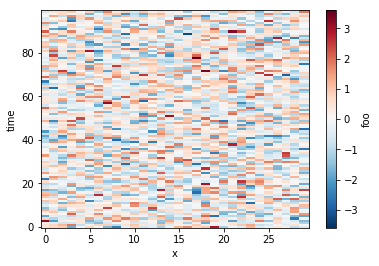

In [1]:
import xarray as xr
import numpy as np
%matplotlib inline

nt, nx = 100, 30
da = xr.DataArray(np.random.randn(nt, nx), dims=['time', 'x'],
                  name='foo') # all inputs need a name
display(da)
da.plot()

By default xhistogram operates on all dimensions of an array, just like numpy. However, it operates on xarray DataArrays, taking labels into account.

<xarray.DataArray 'histogram_foo' (foo_bin: 19)>
array([  0,   1,   5,  23,  51, 141, 235, 337, 446, 505, 456, 374, 221, 129,
        45,  19,   7,   4,   1])
Coordinates:
  * foo_bin  (foo_bin) float64 -3.789 -3.368 -2.947 -2.526 ... 2.947 3.368 3.789

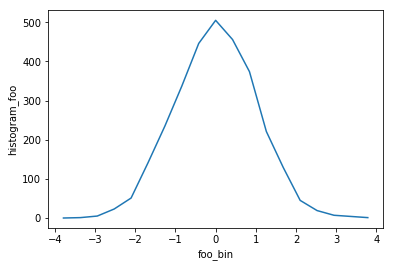

In [2]:
from xhistogram.xarray import histogram

bins = np.linspace(-4, 4, 20)
h = histogram(da, bins=[bins])
display(h)
h.plot()

**TODO:** 
- Bins needs to be a list; this is annoying, would be good to accept single items
- The `foo_bin` coordinate is the estimated bin center, not the bounds. We need to add the bounds to the coordinates, but we can as long as we are returning DataArray and not Dataset.

Both of the above need GitHub Issues

### Histogram over a single axis

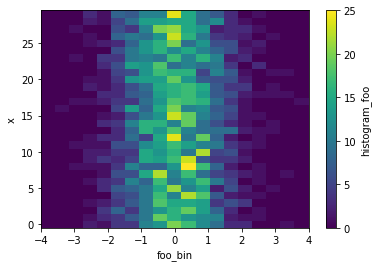

In [3]:
h_x = histogram(da, bins=[bins], dim=['time'])
h_x.plot()

**TODO:**
  - Relax / explain requirement that dims is always a list

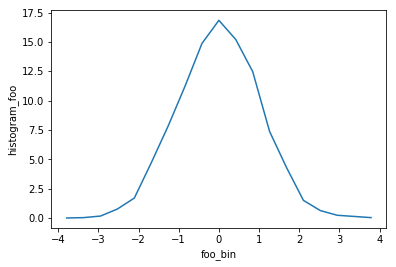

In [4]:
h_x.mean(dim='x').plot()

### Weighted Histogram

Weights can be the same shape as the input:

In [5]:
weights = 0.4 * xr.ones_like(da)
histogram(da, bins=[bins], weights=weights)

<xarray.DataArray 'histogram_foo' (foo_bin: 19)>
array([  0. ,   0.4,   2. ,   9.2,  20.4,  56.4,  94. , 134.8, 178.4, 202. ,
       182.4, 149.6,  88.4,  51.6,  18. ,   7.6,   2.8,   1.6,   0.4])
Coordinates:
  * foo_bin  (foo_bin) float64 -3.789 -3.368 -2.947 -2.526 ... 2.947 3.368 3.789

Or can use Xarray broadcasting:

In [6]:
weights = 0.2 * xr.ones_like(da.x)
histogram(da, bins=[bins], weights=weights)

<xarray.DataArray 'histogram_foo' (foo_bin: 19)>
array([  0. ,   0.2,   1. ,   4.6,  10.2,  28.2,  47. ,  67.4,  89.2, 101. ,
        91.2,  74.8,  44.2,  25.8,   9. ,   3.8,   1.4,   0.8,   0.2])
Coordinates:
  * foo_bin  (foo_bin) float64 -3.789 -3.368 -2.947 -2.526 ... 2.947 3.368 3.789

## 2D Histogram

Now let's say we have multiple input arrays. We can calculate their joint distribution:

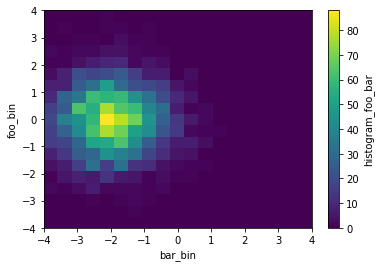

In [7]:
db = xr.DataArray(np.random.randn(nt, nx), dims=['time', 'x'],
                  name='bar') - 2

histogram(da, db, bins=[bins, bins]).plot()

## Real Data Example

### Ocean Volume Census in TS Space

Here we show how to use xhistogram to do a volume census of the ocean in Temperature-Salinity Space

First we open the dataset which has been derived from the World Ocean Atlas 2018 (https://www.nodc.noaa.gov/OC5/woa18/). This derived data set contains the Temparature, Salinity and Oxygen on a 5degree grid

In [10]:
Ocean_TS = xr.open_dataset('../datasets/Ocean_TS_5deg.nc')
Ocean_TS

<xarray.Dataset>
Dimensions:  (depth: 102, lat: 36, lon: 72)
Coordinates:
  * depth    (depth) float32 0.0 5.0 10.0 15.0 ... 5200.0 5300.0 5400.0 5500.0
  * lat      (lat) float32 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5
  * lon      (lon) float32 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
Data variables:
    SA       (depth, lat, lon) float64 ...
    CT       (depth, lat, lon) float64 ...
    O2       (depth, lat, lon) float32 ...
    dz       (depth) float32 ...

Use histogram to bin data points. Use canonical ocean T/S ranges, and bin size of $0.1^0C$, and $0.025psu$. Similar ranges and bin size as this review paper on Mode Waters: https://doi.org/10.1016/B978-0-12-391851-2.00009-X .

In [66]:
sbins = np.arange(31,38, 0.025)
tbins = np.arange(-2, 32, 0.1)

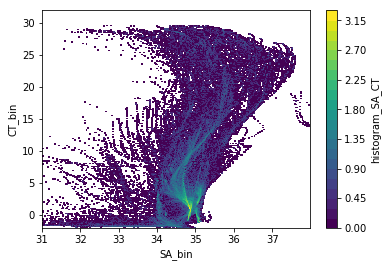

In [70]:
# histogram of number of data points
hTS = histogram(Ocean_TS.SA, Ocean_TS.CT, bins=[sbins, tbins])
np.log10(hTS.T).plot(levels=31)

However, we would like to do a volume census, which requires the data points to be weighted by volume of the grid box. 

\begin{equation}
dV = dz*dx*dy
\end{equation}

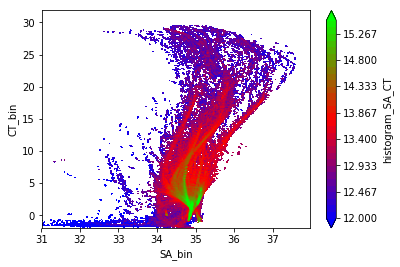

In [103]:
# histogram of number of data points weighted by volume resolution
# Note that depth is a non-uniform axis

# weight by volume of grid cell (resolution = 5degree, 1degree=110km)
dVol = Ocean_TS.dz*(5*110e3)*(5*110e3*np.cos(Ocean_TS.lat*np.pi/180)) 

# Note: The weights are automatically broadcast to the right size
hTSw = histogram(Ocean_TS.SA, Ocean_TS.CT, bins=[sbins, tbins], weights=dVol)
np.log10(hTSw.T).plot.contourf(levels=31, vmin=12, vmax=15.5, cmap='brg')

The ridges of this above plot are indicative of T/S classes with a lot of volume, and some of them are indicative of Mode Waters (example Eighteen Degree water with T$\sim18^oC$, and S$\sim36.5psu$. 

#### Averaging a variable 

Next we calculate the mean oxygen value in each TS bin. 

\begin{equation}
\overline{A} (m,n) = \frac{\sum_{T(x,y,z)=m, S(x,y,z)=n} (A(x,y,z) dV)}{\sum_{T(x,y,z)=m, S(x,y,z)=n}dV}.
\end{equation}

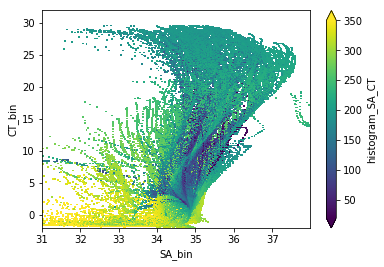

In [104]:
hTSO2 = (histogram(Ocean_TS.SA.where(~np.isnan(Ocean_TS.O2)), 
                   Ocean_TS.CT.where(~np.isnan(Ocean_TS.O2)), 
                   bins=[sbins, tbins], 
                   weights=Ocean_TS.O2.where(~np.isnan(Ocean_TS.O2))*dVol)/
                histogram(Ocean_TS.SA.where(~np.isnan(Ocean_TS.O2)), 
                   Ocean_TS.CT.where(~np.isnan(Ocean_TS.O2)), 
                   bins=[sbins, tbins], 
                   weights=dVol))

(hTSO2.T).plot(vmin=20, vmax=350)

Some interesting patterns in average oxygen emerge. Convectively ventilated cold water have the highest oxygen and mode waters have relatively high oxygen. Oxygen minimum zones are interspersed in the middle of volumetic ridges (high volume waters). 

TODO: NaNs in weights are not handled properly, and a few nanvalues make the weighted sum as nan. Maybe use nansum.

## Dask Integration

Should just work, but need examples.